# Modeling

In [1]:
## Import all the libraries
import pandas as pd
import numpy as np

## Data Viz 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
from matplotlib import rc

## Transformation
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

## for statistical tests
from math import sqrt
import scipy
from scipy.fft import fft, fftfreq
import statistics
from statistics import mean

## SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.svm import SVC

## Cluster Centroids
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans

## Modelling 
from sklearn import datasets, decomposition, ensemble, feature_selection, linear_model, metrics, model_selection, preprocessing, svm, tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, make_scorer, confusion_matrix, explained_variance_score, f1_score, mean_absolute_error, mean_squared_error, precision_score, r2_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, auc, precision_recall_fscore_support
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, GridSearchCV, ShuffleSplit, train_test_split, RandomizedSearchCV
from sklearn.calibration import calibration_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
# from xgboost import XGBClassifier
# import xgboost as xgb

import shap

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import time

from tabulate import tabulate

import utilityfunctions as uf

import os

print('Libraries imported successfully')

Libraries imported successfully


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [69]:
# set the style for the notebook, in this case colorblind, alternative would be grayscale
uf.set_custom_palette("colorblind")
figures_folder = '../reports/figures' 

In [3]:
# Set random seed for NumPy
np.random.seed(42)

In [4]:
# Load Code for GitHub
df = pd.read_csv('arrhythmia_preprocessed_cleaned_classes_label.csv')

# Seperate Features, Standardize and Split

In [5]:
# Separate features and target variable
X = df.drop(['class','label'], axis=1)  # Features
y = df['label']  # Target variable

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Save X train and X_test without PCA 
X_train_saved = X_train
X_test_saved = X_test
y_train_saved = y_train
y_test_saved = y_test

## PCA - Principal Component Analysis

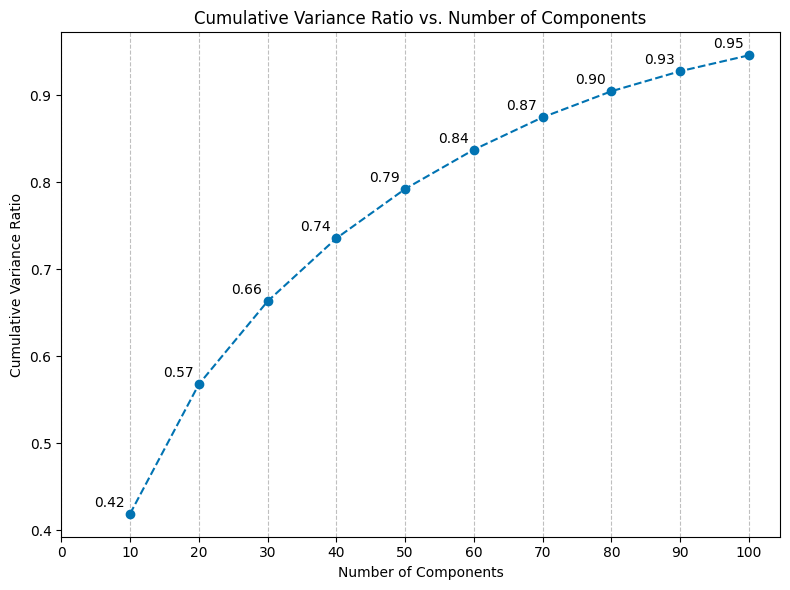

In [70]:
# Define different numbers of components to try
n_components_list = [10,20,30,40,50,60,70,80,90,100]
cumulative_variance_ratios = []

# Initialize a list to store transformed dataframes
transformed_dataframes = []

for n_components in n_components_list:
    # Instantiate PCA with desired number of components
    pca = PCA(n_components=n_components)
    
    # Fit PCA to the standardized data
    pca.fit(X_scaled)
    
    # Transform the data into the new feature space
    X_pca = pca.transform(X_scaled)
    
    # Save the transformed data in a dataframe
    transformed_dataframes.append(pd.DataFrame(X_pca))
    
    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = sum(explained_variance_ratio)
    cumulative_variance_ratios.append(cumulative_variance_ratio)

# Plot cumulative variance ratio
plt.figure(figsize=(8, 6))
plt.plot(n_components_list, cumulative_variance_ratios, marker='o', linestyle='--')
plt.title('Cumulative Variance Ratio vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Ratio')

# Set x-ticks to intervals of 10
plt.xticks(np.arange(0, max(n_components_list) + 1, 10))

# Add vertical grid lines in grey
plt.grid(True, axis='x', color='grey', linestyle='--', alpha=0.5)

# Add annotations
for i, txt in enumerate(cumulative_variance_ratios):
    plt.annotate(f'{txt:.2f}', (n_components_list[i], cumulative_variance_ratios[i]), textcoords="offset points", xytext=(-15,5), ha='center')
plt.tight_layout()

# Save the plot into the figures folder with a proper filename prefix
filename = 'uci_PCA_cumulative_variance_ratio_vs_nr_components.png'
filepath = os.path.join(figures_folder, filename)
plt.savefig(filepath)

plt.show()


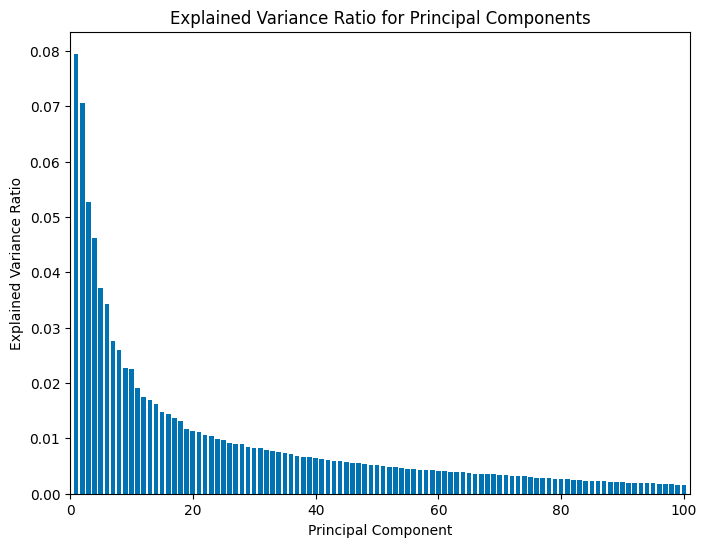

In [7]:
# Re-run PCA with the selected number of components 
X_pca = pca.fit_transform(X_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Visualize the explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, width=0.75)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components')
plt.xlim(0, len(explained_variance_ratio) + 1)
#plt.ylim(0, 1)

# Save the plot into the figures folder with a proper filename prefix and reference
filename = 'uci_explained_variance_ratio.png'
filepath = os.path.join(figures_folder, filename)
plt.savefig(filepath)

plt.show()


# Setting the PCA Threshold for the Training & Test Datasets

In [8]:
# PCA on training data set 
pca = PCA(n_components = .9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(pca.n_components_)

71


In [9]:
# Initialize PCA with 'mle' to automatically determine the number of components
#pca = PCA(n_components='mle')
# Fit PCA to the standardized data
#pca.fit(X_scaled)
# Get the number of components that explain at least 90% of the variance
#n_components = pca.explained_variance_ratio_.cumsum().searchsorted(0.90) + 1
# Print the selected number of components
#print(f'Selected number of components: {n_components}')

In [10]:
#SMOTE
#smo = SMOTE()
#X_train_sm, y_train_sm = smo.fit_resample(X_train, y_train)

#print("Shape of X_train resampled with smote:", X_train_sm.shape)
#print("Shape of y_train resampled with smote:", y_train_sm.shape)
#print('SMOTE :', dict(pd.Series(y_train_sm).value_counts()))

# Set X_train and X_test 

In [11]:
X_train = X_train_pca
X_test = X_test_pca
print(X_train.shape)
print(X_test.shape)

(361, 71)
(91, 71)


**Model Experiments**

# Define Classifiers and parameters

In [12]:

# Define classifiers with specified parameters
clf_lr = LogisticRegression(random_state=22, max_iter=2000)
clf_rf = RandomForestClassifier(random_state=22)
clf_svc = SVC(random_state=22)
clf_en = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)
clf_gb = GradientBoostingClassifier(random_state=42)
clf_ada = AdaBoostClassifier()
# clf_xgb = xgb.XGBClassifier()


# Define parameter grids for each classifier
param_grid_lr = [{'C': [c], 'penalty': [penalty]} for c in np.logspace(-4, 2, 9) for penalty in ['l1', 'l2']]

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000], 
                  'min_samples_leaf': [1, 3, 5], 
                  'max_features': ['sqrt', 'log2']}]

param_grid_svc = {'C': np.logspace(-4, 2, 9), 'kernel': ['linear', 'rbf']}
param_grid_svc_list = [{'C': [c], 'kernel': [kernel]} for c in np.logspace(-4, 2, 9) for kernel in ['linear', 'rbf']]

param_grid_en = {'C': np.logspace(-4, 2, 9), 'l1_ratio': np.linspace(0.1, 0.9, 9)}
param_grid_en_list = [{'C': [C], 'l1_ratio': [l1_ratio]} for C in np.logspace(-4, 2, 9) for l1_ratio in np.linspace(0.1, 0.9, 9)]


param_grid_gb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0], 'max_depth': [3, 5, 7]}
param_grid_gb_list = [{'n_estimators': [n_estimators], 'learning_rate': [learning_rate], 'max_depth': [max_depth]} 
                                 for n_estimators in [50, 100, 200] 
                                 for learning_rate in [0.01, 0.1, 1.0] 
                                 for max_depth in [3, 5, 7]]

param_grid_ada = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}
param_grid_ada_list = [{'n_estimators': [n_estimators], 'learning_rate': [learning_rate]} 
                       for n_estimators in [50, 100, 200] 
                       for learning_rate in [0.01, 0.1, 1.0]]

# param_grid_xgb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0], 'max_depth': [3, 5, 7]}
# param_grid_xgb_list = [{'n_estimators': [n_estimators], 'learning_rate': [learning_rate], 'max_depth': [max_depth]} 
#                       for n_estimators in [50, 100, 200] 
#                       for learning_rate in [0.01, 0.1, 1.0] 
#                       for max_depth in [3, 5, 7]]

print('parameters set')

parameters set


# Logistic Regression

In [24]:
# Logistic Regression
print("Logistic Regression")

# Perform hyperparameter tuning for LogReg
best_params_lr, train_metrics_lr, \
test_metrics_lr, elapsed_total_lr = uf.perform_randomized_search(
    clf_lr,  param_grid_lr, 
    X_train, y_train, 
    X_test, y_test)

# Fit the model with the best hyperparameters
clf_lr_best = LogisticRegression(**best_params_lr)
clf_lr_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_lr = clf_lr_best.predict(X_train)
test_predictions_lr = clf_lr_best.predict(X_test)

# Store results 
lr_results = {
    'best_params': best_params_lr,
    'train_metrics': train_metrics_lr,
    'test_metrics': test_metrics_lr,
    'elapsed_total': elapsed_total_lr,
    'test_predictions': test_predictions_lr,
}

# Displaying the model metrics
print("Best Parameters:", best_params_lr)
uf.display_metrics('Logistic Regression', train_metrics_lr, test_metrics_lr)

Logistic Regression
Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l2; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ................C=0.0031622776601683794, penalty=l2; total time=   0.0s[CV] END ................C=0.0031622776601683794, penalty=l2; total time=   0.0s
[CV] END ................C=0.0031622776601683794, penalty=l2; total time=   0.0s

[CV] END ................C=0

,accuracy,precision,recall,f1,roc_auc
Train,0.8476,0.8671,0.7750,0.8185,0.8402
Test,0.6484,0.7273,0.5106,0.6000,0.6530


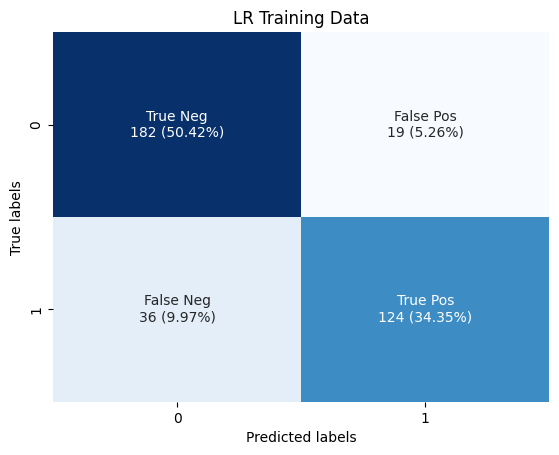

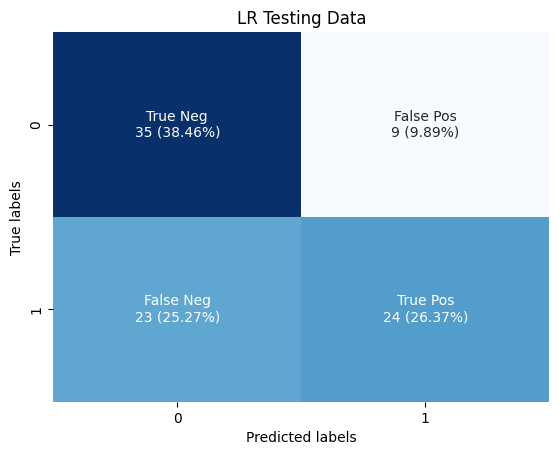

In [23]:
# Plot confusion matrix for training data
conf_matrix_train = confusion_matrix(y_train, train_predictions_lr)
total_train = np.sum(conf_matrix_train)
labels_train = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
labels_train = [f'{name}\n{count} ({count/total_train:.2%})' for name, count in zip(labels_train, conf_matrix_train.flatten())]
labels_train = np.asarray(labels_train).reshape(2, 2)
sns.heatmap(conf_matrix_train, annot=labels_train, fmt='', cmap='Blues', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('LR Training Data')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(os.path.join(figures_folder, 'uci_lr_confusion_matrix_train.png'))
plt.show()

# Plot confusion matrix for testing data
conf_matrix_test = confusion_matrix(y_test, test_predictions_lr)
total_test = np.sum(conf_matrix_test)
labels_test = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
labels_test = [f'{name}\n{count} ({count/total_test:.2%})' for name, count in zip(labels_test, conf_matrix_test.flatten())]
labels_test = np.asarray(labels_test).reshape(2, 2)
sns.heatmap(conf_matrix_test, annot=labels_test, fmt='', cmap='Blues', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('LR Testing Data')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(os.path.join(figures_folder, 'uci_lr_confusion_matrix_test.png'))
plt.show()

# Random Forest

In [26]:
print("Random Forest")
# Perform hyperparameter tuning for RandomForest
best_params_rf, train_metrics_rf, test_metrics_rf, elapsed_total_rf = uf.perform_randomized_search(clf_rf, param_grid_rf, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_rf_best = RandomForestClassifier(**best_params_rf)
clf_rf_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_rf = clf_rf_best.predict(X_train)
test_predictions_rf = clf_rf_best.predict(X_test)

# Store results 
rf_results = {
    'best_params': best_params_rf,
    'train_metrics': train_metrics_rf,
    'test_metrics': test_metrics_rf,
    'elapsed_total': elapsed_total_rf,
    'test_predictions': test_predictions_rf,
}

# Displaying the model metrics
print("Best Parameters:", best_params_rf)
uf.display_metrics('Random Forest', train_metrics_rf, test_metrics_rf)


Random Forest
Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1000; total time=   3.6s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1000; total time=   3.7s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=3, n_estimators=100; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=10; total time=   0.1s
[CV] END max_features=log2, min_samples_leaf

,accuracy,precision,recall,f1,roc_auc
Train,0.9723,0.9870,0.9500,0.9682,0.9700
Test,0.7033,0.7941,0.5745,0.6667,0.7077


# SVC

In [31]:
print("SVC")
# Perform hyperparameter tuning for RandomForest
best_params_svc, train_metrics_svc, test_metrics_svc, elapsed_total_svc = uf.perform_randomized_search(clf_svc, param_grid_svc, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_svc_best = SVC(**best_params_svc)
clf_svc_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_svc = clf_svc_best.predict(X_train)
test_predictions_svc = clf_svc_best.predict(X_test)

# Store results 
svc_results = {
    'best_params': best_params_svc,
    'train_metrics': train_metrics_svc,
    'test_metrics': test_metrics_svc,
    'elapsed_total': elapsed_total_svc,
    'test_predictions': test_predictions_svc
}

# Displaying the model metrics
print("Best Parameters:", best_params_svc)
uf.display_metrics('SVC', train_metrics_svc, test_metrics_svc)

SVC
Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...............................C=0.0001, kernel=rbf; total time=   0.0s
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ................C=0.0031622776601683794, kernel=rbf; total time=   0.0s
[CV] END ................C=0.0031622776601683794, kernel=rbf; total time=   0.0s
[CV] END .

,accuracy,precision,recall,f1,roc_auc
Train,0.9030,0.9699,0.8062,0.8805,0.8932
Test,0.7473,0.8750,0.5957,0.7089,0.7524


# ElasticNet

In [34]:
print("ElasticNet")
# Perform hyperparameter tuning for ElasticNet
best_params_en, train_metrics_en, test_metrics_en, elapsed_total_en = uf.perform_randomized_search(clf_en, param_grid_en, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_en_best = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, **best_params_en)
clf_en_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_en = clf_en_best.predict(X_train)
test_predictions_en = clf_en_best.predict(X_test)

# Store results 
en_results = {
    'best_params': best_params_en,
    'train_metrics': train_metrics_en,
    'test_metrics': test_metrics_en,
    'elapsed_total': elapsed_total_en,
    'test_predictions': test_predictions_en
}

# Displaying the model metrics
print("Best Parameters:", best_params_en)
uf.display_metrics('ElasticNet', train_metrics_en, test_metrics_en)

ElasticNet
Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ................C=0.01778279410038923, l1_ratio=0.4; total time=   0.0s
[CV] END ................C=0.01778279410038923, l1_ratio=0.4; total time=   0.1s
[CV] END .............................C=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END .............................C=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END .............................C=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END ..............C=0.0031622776601683794, l1_ratio=0.5; total time=   0.0s
[CV] END ................C=0.01778279410038923, l1_ratio=0.4; total time=   0.1s
[CV] END ..............C=0.0031622776601683794, l1_ratio=0.5; total time=   0.0s
[CV] END ..............C=0.0031622776601683794, l1_ratio=0.5; total time=   0.0s
[CV] END ................C=0.01778279410038923, l1_ratio=0.5; total time=   0.0s
[CV] END ................C=0.01778279410038923, l1_ratio=0.5; total time=   0.0s
[CV

,accuracy,precision,recall,f1,roc_auc
Train,0.8061,0.8516,0.6812,0.7569,0.7934
Test,0.7033,0.8125,0.5532,0.6582,0.7084


# Gradientboost

In [35]:
print("Gradient Boosting Classifier")
# Perform hyperparameter tuning for GBoost
best_params_gb, train_metrics_gb, test_metrics_gb, elapsed_total_gb = uf.perform_randomized_search(clf_gb, param_grid_gb, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_gb_best = GradientBoostingClassifier(**best_params_gb)
clf_gb_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_gb = clf_gb_best.predict(X_train)
test_predictions_gb = clf_gb_best.predict(X_test)

# Store results 
gb_results = {
    'best_params': best_params_gb,
    'train_metrics': train_metrics_gb,
    'test_metrics': test_metrics_gb,
    'elapsed_total': elapsed_total_gb,
    'test_predictions': test_predictions_gb
}

# Displaying the model metrics
print("Best Parameters:", best_params_gb)
uf.display_metrics('Gradient Boost', train_metrics_gb, test_metrics_gb)

Gradient Boosting Classifier
Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   4.2s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   4.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.8s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.8s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   3.7s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.7s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ....learning_rate=1.0, max_depth=5, n_estimators=50; total time=   0.6s
[CV] END ....learning_rate=1.0, max_depth=5, n_estimators=50; tota

,accuracy,precision,recall,f1,roc_auc
Train,1.0000,1.000,1.0000,1.0000,1.0000
Test,0.7363,0.871,0.5745,0.6923,0.7418


# Adaboost

In [36]:
print("AdaBoost Classifier")
# Perform hyperparameter tuning for AdaBoost
best_params_ada, train_metrics_ada, test_metrics_ada, elapsed_total_ada = uf.perform_randomized_search(clf_ada, param_grid_ada, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_ada_best = AdaBoostClassifier(**best_params_ada)
clf_ada_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_ada = clf_ada_best.predict(X_train)
test_predictions_ada = clf_ada_best.predict(X_test)

# Store results 
ada_results = {
    'best_params': best_params_ada,
    'train_metrics': train_metrics_ada,
    'test_metrics': test_metrics_ada,
    'elapsed_total': elapsed_total_ada,
    'test_predictions': test_predictions_ada
}

# Displaying the model metrics
print("Best Parameters:", best_params_ada)
uf.display_metrics('Ada Boost', train_metrics_ada, test_metrics_ada)

AdaBoost Classifier
Starting hyperparameter search...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   0.4s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   0.4s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   0.4s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.8s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.8s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.7s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   1.4s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   1.5s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=   0.4s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=   0.4s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   

,accuracy,precision,recall,f1,roc_auc
Train,0.9197,0.9712,0.8438,0.9030,0.9119
Test,0.7143,0.8889,0.5106,0.6486,0.7212


# XGBoost

In [ ]:
print("XGBoost Classifier")
# Perform hyperparameter tuning for XGBoost
best_params_xgb, train_metrics_xgb, test_metrics_xgb, elapsed_total_xgb = perform_randomized_search(clf_xgb, param_grid_xgb, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_xgb_best = XGBClassifier(**best_params_xgb)
clf_xgb_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_xgb = clf_xgb_best.predict(X_train)
test_predictions_xgb = clf_xgb_best.predict(X_test)

# Store results 
xgb_results = {
    'best_params': best_params_xgb,
    'train_metrics': train_metrics_xgb,
    'test_metrics': test_metrics_xgb,
    'elapsed_total': elapsed_total_xgb,
    'test_predictions': test_predictions_xgb
}

# Displaying the model metrics
print("Best Parameters:", best_params_xgb)
display_metrics('XGBoost', train_metrics_xgb, test_metrics_xgb)

# Plot confusion matrix for training data
titles = ['XGB Training Data', 'XGB Testing Data']
plot_confusion_matrices_side_by_side('XGBoost', [(y_train, train_predictions_xgb), (y_test, test_predictions_xgb)], titles)

# Model Comparison

In [37]:
original_results = [lr_results, rf_results, svc_results, en_results, ada_results, gb_results]

In [38]:
# Define model names and their corresponding results
models = ['LR', 'RF', 'SVC', 'EN', 'ADA', 'GB']
results = [lr_results, rf_results, svc_results, en_results, ada_results, gb_results]

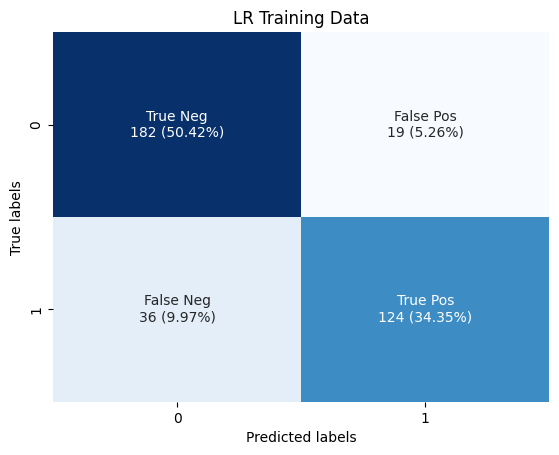

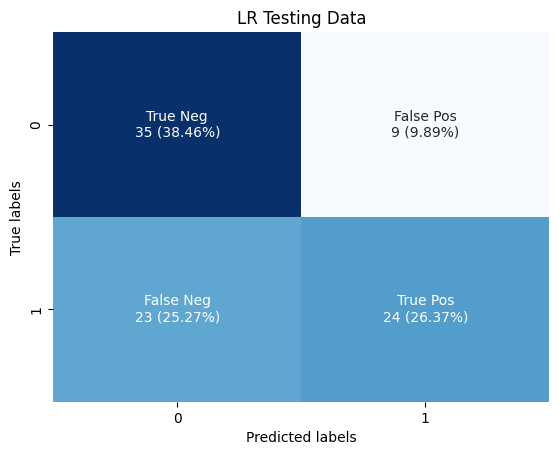

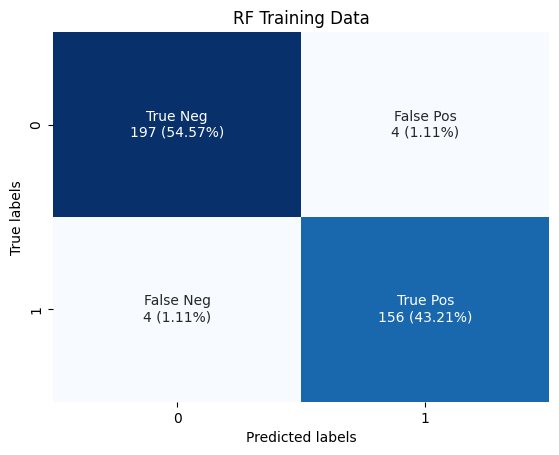

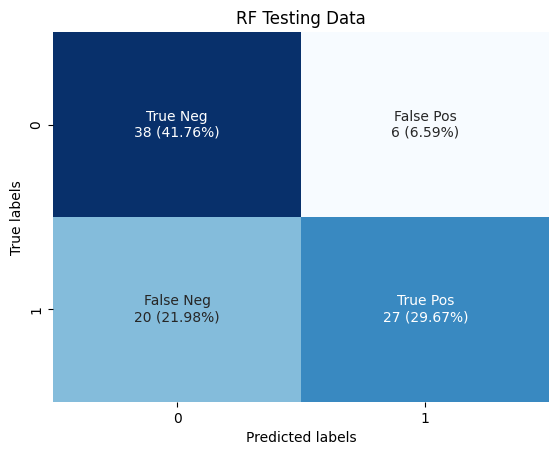

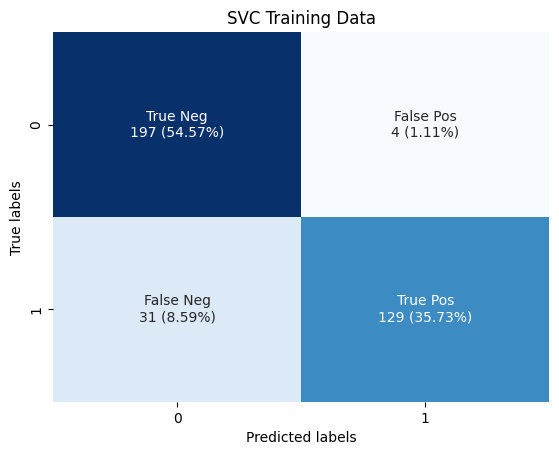

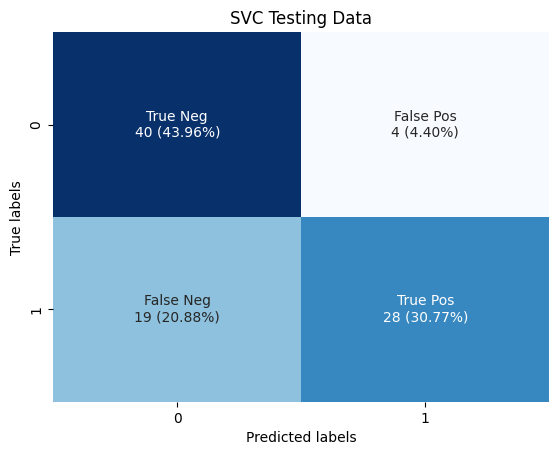

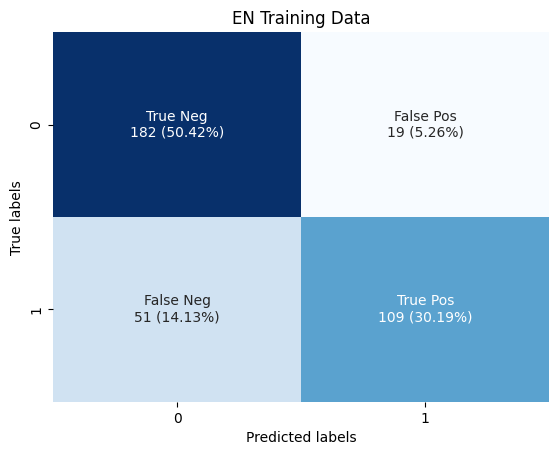

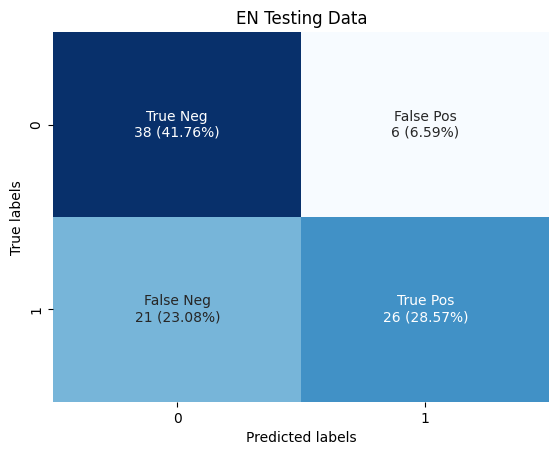

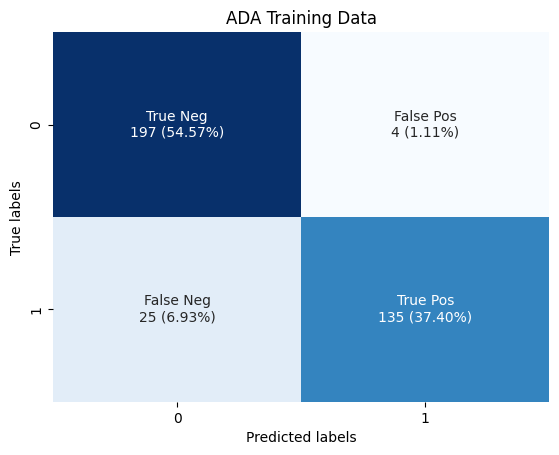

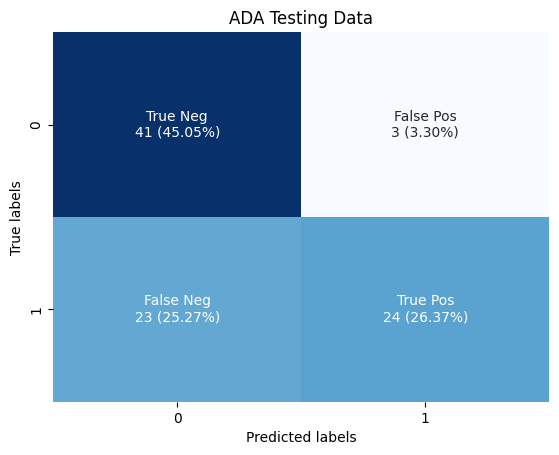

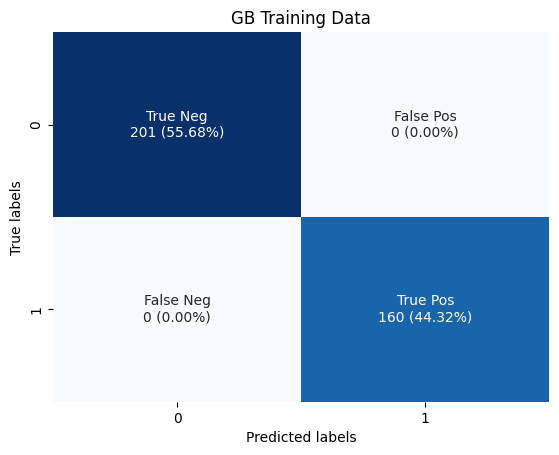

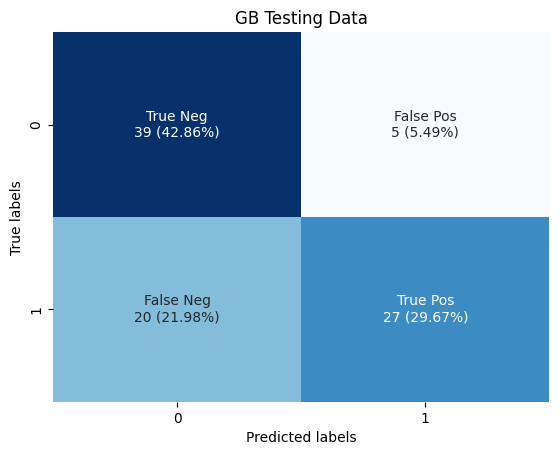

In [39]:
# Plot each Correlation Matrix
# Define model names

# Define model prediction results
model_predictions = {
    'LR': (train_predictions_lr, test_predictions_lr),
    'RF': (train_predictions_rf, test_predictions_rf),
    'SVC': (train_predictions_svc, test_predictions_svc),
    'EN': (train_predictions_en, test_predictions_en),
    'ADA': (train_predictions_ada, test_predictions_ada),
    'GB': (train_predictions_gb, test_predictions_gb),
#    'XGB': (train_predictions_xgb, test_predictions_xgb)
}

# Iterate over model names
for model_name in models:
    # Get predictions for the current model
    train_predictions, test_predictions = model_predictions[model_name]
    
    # Plot confusion matrix for training data
    conf_matrix_train = confusion_matrix(y_train, train_predictions)
    total_train = np.sum(conf_matrix_train)
    labels_train = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    labels_train = [f'{name}\n{count} ({count/total_train:.2%})' for name, count in zip(labels_train, conf_matrix_train.flatten())]
    labels_train = np.asarray(labels_train).reshape(2, 2)
    sns.heatmap(conf_matrix_train, annot=labels_train, fmt='', cmap='Blues', cbar=False,
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(f'{model_name} Training Data')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.savefig(os.path.join(figures_folder, f'uci_{model_name}_confusion_matrix_train.png'))
    plt.show()

    # Plot confusion matrix for testing data
    conf_matrix_test = confusion_matrix(y_test, test_predictions)
    total_test = np.sum(conf_matrix_test)
    labels_test = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    labels_test = [f'{name}\n{count} ({count/total_test:.2%})' for name, count in zip(labels_test, conf_matrix_test.flatten())]
    labels_test = np.asarray(labels_test).reshape(2, 2)
    sns.heatmap(conf_matrix_test, annot=labels_test, fmt='', cmap='Blues', cbar=False,
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(f'{model_name} Testing Data')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.savefig(os.path.join(figures_folder, f'uci_{model_name}_confusion_matrix_test.png'))
    plt.show()

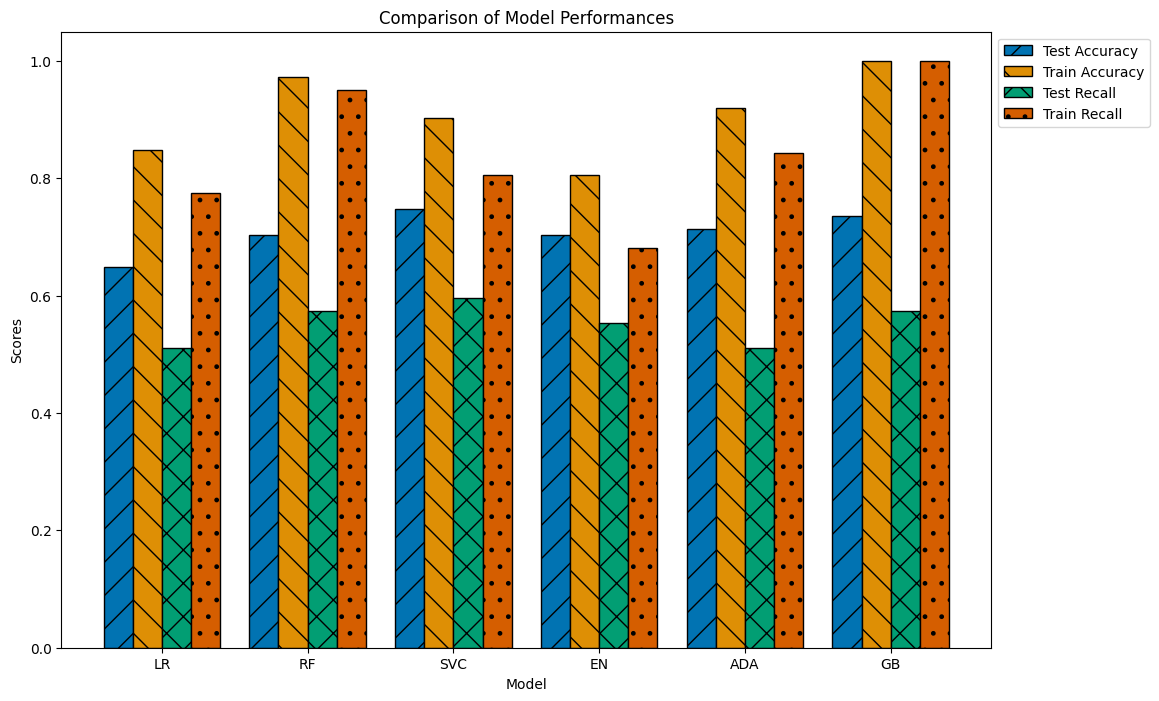

In [40]:
# Extract test and train accuracy scores for each model
test_accuracies = [result['test_metrics']['accuracy'] for result in results]
train_accuracies = [result['train_metrics']['accuracy'] for result in results]

# Extract test and train recall scores for each model
test_recalls = [result['test_metrics']['recall'] for result in results]
train_recalls = [result['train_metrics']['recall'] for result in results]

# Bar width
bar_width = 0.2
index = np.arange(len(models))
# Bar width
bar_width = 0.2
index = np.arange(len(models))

# Plotting
plt.figure(figsize=(12, 8))

# Plot test accuracy
plt.bar(index, test_accuracies, bar_width, edgecolor='black', hatch='/', label='Test Accuracy')
# Plot train accuracy
plt.bar(index + bar_width, train_accuracies, bar_width, edgecolor='black', hatch='\\', label='Train Accuracy')

# Plot test recall
plt.bar(index + 2*bar_width, test_recalls, bar_width, edgecolor='black', hatch='x', label='Test Recall')
# Plot train recall
plt.bar(index + 3*bar_width, train_recalls, bar_width, edgecolor='black', hatch='.', label='Train Recall')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Model Performances')
plt.xticks(index + 1.5*bar_width, models)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.show()


# AUROC for best performing models

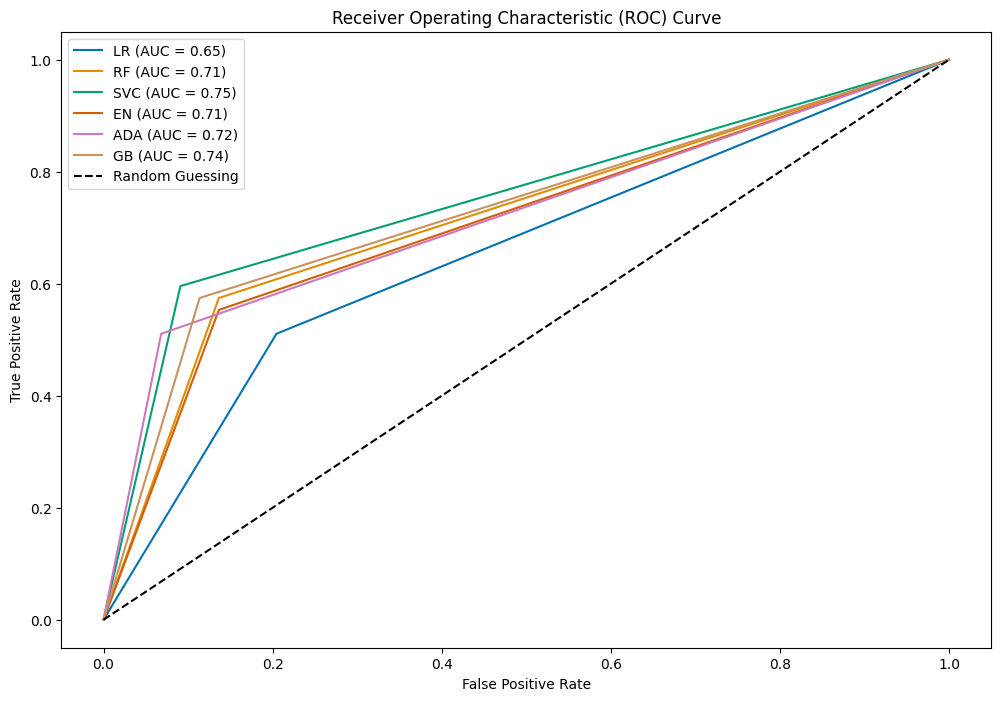

In [41]:
# Plot ROC curves for each model
plt.figure(figsize=(12, 8))

for model_name, result in zip(models, results):
    # Get the correct test predictions variable for the current model
    if 'test_predictions' in result:
        test_predictions = result['test_predictions']
    elif 'test_metrics' in result and 'predictions' in result['test_metrics']:
        test_predictions = result['test_metrics']['predictions']
    else:
        raise KeyError(f"Test predictions not found for model: {model_name}")
        
    # Compute ROC curve for test data
    fpr, tpr, _ = roc_curve(y_test, test_predictions)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["test_metrics"]["roc_auc"]:.2f})')

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.show()


# Model Metrics Display with Highlights

In [42]:
# Function to apply different highlighting based on column names
def highlight_max_min(col):
    if col.name.startswith('Elapsed Total Time (s)'):
        max_val = col.max()
        min_val = col.min()
        return ['background-color: #FFD699' if x == max_val else 'background-color: #ADD8E6' if x == min_val else '' for x in col]
    else:
        return ['background-color: #D3ECA1' if x == col.max() else '' for x in col]

In [45]:
# Define model names and their corresponding results
models = ['LR', 'RF', 'SVC', 'EN', 'ADA', 'GB']
original_results = [lr_results, rf_results, svc_results, en_results, ada_results, gb_results]

# Create a list of dictionaries containing the test scores and elapsed total time for each model
original_scores = []
for model_name, result in zip(models, original_results):
    original_scores.append({
        'Model': model_name,
        'Accuracy': result['test_metrics']['accuracy'],
        'Precision': result['test_metrics']['precision'],
        'Recall': result['test_metrics']['recall'],
        'F1 Score': result['test_metrics']['f1'],
        'ROC AUC': result['test_metrics']['roc_auc'],
        'Elapsed Total Time (s)': result['elapsed_total']
    })

# Create a DataFrame from the list of dictionaries
scores_df = pd.DataFrame(original_scores)

# Set the 'Model' column as the index
scores_df.set_index('Model', inplace=True)

# Find the maximum value for each train score
max_accuracy = scores_df['Accuracy'].max()
max_recall = scores_df['Recall'].max()
max_precision = scores_df['Precision'].max()
max_f1 = scores_df['F1 Score'].max()
max_roc_auc = scores_df['ROC AUC'].max()

# Find the minimum value for elapsed total time
min_time = scores_df['Elapsed Total Time (s)'].min()
max_time = scores_df['Elapsed Total Time (s)'].max()

scores_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Elapsed Total Time (s)
Model,,,,,,
LR,0.648352,0.727273,0.510638,0.600000,0.653046,12.507556
RF,0.703297,0.794118,0.574468,0.666667,0.707689,33.811905
SVC,0.747253,0.875000,0.595745,0.708861,0.752418,41.766740
EN,0.703297,0.812500,0.553191,0.658228,0.708414,16.300562
ADA,0.714286,0.888889,0.510638,0.648649,0.721228,23.472109
GB,0.736264,0.870968,0.574468,0.692308,0.741779,38.634864


In [46]:
# Apply the styling function to highlight the maximum value in each column
styled_df = scores_df.style.apply(highlight_max_min)

# Display the styled DataFrame
styled_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Elapsed Total Time (s)
Model,,,,,,
LR,0.648352,0.727273,0.510638,0.600000,0.653046,12.507556
RF,0.703297,0.794118,0.574468,0.666667,0.707689,33.811905
SVC,0.747253,0.875000,0.595745,0.708861,0.752418,41.766740
EN,0.703297,0.812500,0.553191,0.658228,0.708414,16.300562
ADA,0.714286,0.888889,0.510638,0.648649,0.721228,23.472109
GB,0.736264,0.870968,0.574468,0.692308,0.741779,38.634864


# CV for Optimal PCA

Best Performing PCA (SVC): 60
Best Cross-validation Accuracy (SVC): 0.7867199391171995


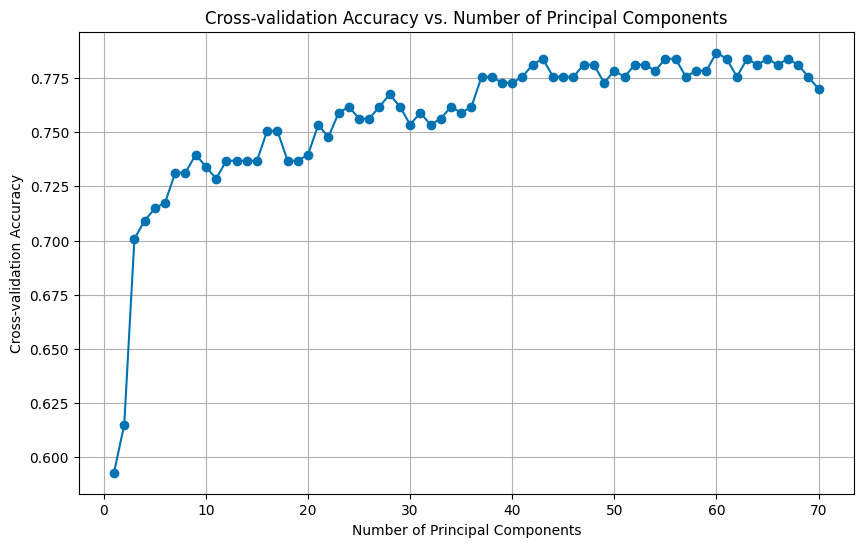

In [47]:
# Extract best parameters if they exist, otherwise set defaults
best_kernel = best_params_svc.get('kernel', 'rbf')
best_C = best_params_svc.get('C', 1.0)

# Define the pipeline with PCA followed by SVC using the best parameters
pipeline = Pipeline([
    ('pca', PCA()),
    ('svc', SVC(kernel=best_kernel, C=best_C)) 
])

num_features = max(X_train.shape[1], 1)
param_grid = {
    'pca__n_components': range(1, min(num_features, 200)),
}

# Define parameter grid for PCA 
#param_grid = {
#    'pca__n_components': range(1, min(X_train.shape[1], 200)),
#}

# Initialize variables to store the best PCA and its corresponding score
best_pca = None
best_score = float('-inf')
mean_scores = []

# Perform grid search with cross-validation
for n_components in param_grid['pca__n_components']:
    # Define the pipeline with PCA followed by SVM using the best parameters
    pipeline = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('svc', SVC(kernel=best_kernel, C=best_C))
    ])
    
    # Perform cross-validation and get mean accuracy
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    mean_score = np.mean(scores)
    
    # Check if the current PCA is better than the previous best
    if mean_score > best_score:
        best_score = mean_score
        best_pca = n_components
    
    # Store the mean accuracy
    mean_scores.append(mean_score)

# Print the best performing PCA and its corresponding score
print("Best Performing PCA (SVC):", best_pca)
print("Best Cross-validation Accuracy (SVC):", best_score)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(param_grid['pca__n_components'], mean_scores, '-o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cross-validation Accuracy')
plt.title('Cross-validation Accuracy vs. Number of Principal Components')
plt.grid(True)
plt.show()


In [48]:
# PCA on training data set 
pca = PCA(n_components = best_pca)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(pca.n_components_)

60


# Rerunning Models with Optimal PCA

In [56]:
# Logistic Regression
print("Logistic Regression")

# Perform hyperparameter tuning for LogReg
best_params_lr, train_metrics_lr, test_metrics_lr, elapsed_total_lr = uf.perform_randomized_search(clf_lr, param_grid_lr, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_lr_best = LogisticRegression(**best_params_lr)
clf_lr_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_lr = clf_lr_best.predict(X_train)
test_predictions_lr = clf_lr_best.predict(X_test)

# Store results 
lr_results = {
    'best_params': best_params_lr,
    'train_metrics': train_metrics_lr,
    'test_metrics': test_metrics_lr,
    'elapsed_total': elapsed_total_lr,
    'test_predictions': test_predictions_lr,
}

# Displaying the model metrics
print("Best Parameters:", best_params_lr)
uf.display_metrics('Logistic Regression', train_metrics_lr, test_metrics_lr)


Logistic Regression
Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l2; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ................C=0.0031622776601683794, penalty=l2; total time=   0.0s
[CV] END ................C=0.0031622776601683794, penalty=l2; total time=  

,accuracy,precision,recall,f1,roc_auc
Train,0.8449,0.8662,0.7688,0.8146,0.8371
Test,0.7143,0.8000,0.5957,0.6829,0.7183


In [57]:
print("Random Forest")
# Perform hyperparameter tuning for RandomForest
best_params_rf, train_metrics_rf, test_metrics_rf, elapsed_total_rf = uf.perform_randomized_search(clf_rf, param_grid_rf, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_rf_best = RandomForestClassifier(**best_params_rf)
clf_rf_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_rf = clf_rf_best.predict(X_train)
test_predictions_rf = clf_rf_best.predict(X_test)

# Store results 
rf_results = {
    'best_params': best_params_rf,
    'train_metrics': train_metrics_rf,
    'test_metrics': test_metrics_rf,
    'elapsed_total': elapsed_total_rf,
    'test_predictions': test_predictions_rf,
}

# Displaying the model metrics
print("Best Parameters:", best_params_rf)
uf.display_metrics('Random Forest', train_metrics_rf, test_metrics_rf)


Random Forest
Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1000; total time=   4.9s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=1000; total time=   5.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.4s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END max_features=log2, min_samples_leaf=3, n_estimators=100; total time=   0.6s
[CV] END max_features=log2, min_samples_leaf=3, n_estimators=100; total time=   0.4s
[CV] END max_features=log2, min_samples_leaf=3, n_estimators=100; total time=   0.6s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=log2, min_samples_leaf=5, n_estimators=10; total time=   0.1s
[CV] END max_features=log2, min_samples_leaf

,accuracy,precision,recall,f1,roc_auc
Train,0.9778,1.0000,0.9500,0.9744,0.9750
Test,0.7253,0.8235,0.5957,0.6914,0.7297


In [58]:
print("SVC")
# Perform hyperparameter tuning for RandomForest
best_params_svc, train_metrics_svc, test_metrics_svc, elapsed_total_svc = uf.perform_randomized_search(clf_svc, param_grid_svc, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_svc_best = SVC(**best_params_svc)
clf_svc_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_svc = clf_svc_best.predict(X_train)
test_predictions_svc = clf_svc_best.predict(X_test)

# Store results 
svc_results = {
    'best_params': best_params_svc,
    'train_metrics': train_metrics_svc,
    'test_metrics': test_metrics_svc,
    'elapsed_total': elapsed_total_svc,
    'test_predictions': test_predictions_svc
}

# Displaying the model metrics
print("Best Parameters:", best_params_svc)
uf.display_metrics('SVC', train_metrics_svc, test_metrics_svc)


SVC
Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ............................C=0.0001, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...............................C=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...............................C=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ................C=0.0031622776601683794, kernel=rbf; total time=   0.0s
[CV] END ................C=0.0031622776601683794, kernel=rbf; total time=   0.0s
[CV] END .

,accuracy,precision,recall,f1,roc_auc
Train,0.8975,0.9695,0.7938,0.8729,0.8869
Test,0.7582,0.8788,0.6170,0.7250,0.7631


In [59]:
print("ElasticNet")
# Perform hyperparameter tuning for ElasticNet
best_params_en, train_metrics_en, test_metrics_en, elapsed_total_en = uf.perform_randomized_search(clf_en, param_grid_en, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_en_best = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, **best_params_en)
clf_en_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_en = clf_en_best.predict(X_train)
test_predictions_en = clf_en_best.predict(X_test)

# Store results 
en_results = {
    'best_params': best_params_en,
    'train_metrics': train_metrics_en,
    'test_metrics': test_metrics_en,
    'elapsed_total': elapsed_total_en,
    'test_predictions': test_predictions_en
}

# Displaying the model metrics
print("Best Parameters:", best_params_en)
uf.display_metrics('ElasticNet', train_metrics_en, test_metrics_en)


ElasticNet
Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ................C=0.01778279410038923, l1_ratio=0.4; total time=   0.0s
[CV] END ................C=0.01778279410038923, l1_ratio=0.4; total time=   0.0s
[CV] END .............................C=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END .............................C=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END .............................C=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END ..............C=0.0031622776601683794, l1_ratio=0.5; total time=   0.0s
[CV] END ................C=0.01778279410038923, l1_ratio=0.4; total time=   0.1s
[CV] END ..............C=0.0031622776601683794, l1_ratio=0.5; total time=   0.0s
[CV] END ..............C=0.0031622776601683794, l1_ratio=0.5; total time=   0.0s
[CV] END ................C=0.01778279410038923, l1_ratio=0.5; total time=   0.0s
[CV] END ................C=0.01778279410038923, l1_ratio=0.5; total time=   0.0s
[CV

,accuracy,precision,recall,f1,roc_auc
Train,0.8033,0.8504,0.6750,0.7526,0.7902
Test,0.7033,0.8125,0.5532,0.6582,0.7084


In [60]:
print("Gradient Boosting Classifier")
# Perform hyperparameter tuning for GBoost
best_params_gb, train_metrics_gb, test_metrics_gb, elapsed_total_gb = uf.perform_randomized_search(clf_gb, param_grid_gb, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_gb_best = GradientBoostingClassifier(**best_params_gb)
clf_gb_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_gb = clf_gb_best.predict(X_train)
test_predictions_gb = clf_gb_best.predict(X_test)

# Store results 
gb_results = {
    'best_params': best_params_gb,
    'train_metrics': train_metrics_gb,
    'test_metrics': test_metrics_gb,
    'elapsed_total': elapsed_total_gb,
    'test_predictions': test_predictions_gb
}

# Displaying the model metrics
print("Best Parameters:", best_params_gb)
uf.display_metrics('Gradient Boost', train_metrics_gb, test_metrics_gb)


Gradient Boosting Classifier
Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   3.6s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   4.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.6s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   3.6s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.7s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.5s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ....learning_rate=1.0, max_depth=5, n_estimators=50; total time=   0.6s
[CV] END ....learning_rate=1.0, max_depth=5, n_estimators=50; tota

,accuracy,precision,recall,f1,roc_auc
Train,1.0000,1.0000,1.0000,1.0000,1.0000
Test,0.7253,0.8235,0.5957,0.6914,0.7297


In [61]:
print("AdaBoost Classifier")
# Perform hyperparameter tuning for AdaBoost
best_params_ada, train_metrics_ada, test_metrics_ada, elapsed_total_ada = uf.perform_randomized_search(clf_ada, param_grid_ada, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_ada_best = AdaBoostClassifier(**best_params_ada)
clf_ada_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_ada = clf_ada_best.predict(X_train)
test_predictions_ada = clf_ada_best.predict(X_test)

# Store results 
ada_results = {
    'best_params': best_params_ada,
    'train_metrics': train_metrics_ada,
    'test_metrics': test_metrics_ada,
    'elapsed_total': elapsed_total_ada,
    'test_predictions': test_predictions_ada
}

# Displaying the model metrics
print("Best Parameters:", best_params_ada)
uf.display_metrics('Ada Boost', train_metrics_ada, test_metrics_ada)


AdaBoost Classifier
Starting hyperparameter search...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   0.6s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   0.6s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   0.5s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.8s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.6s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   0.7s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   1.3s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   1.3s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=   0.3s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=   0.3s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   

,accuracy,precision,recall,f1,roc_auc
Train,0.7341,0.7078,0.6812,0.6943,0.7287
Test,0.6374,0.6944,0.5319,0.6024,0.6410


In [62]:
print("XGBoost Classifier")
# Perform hyperparameter tuning for XGBoost
best_params_xgb, train_metrics_xgb, test_metrics_xgb, elapsed_total_xgb = uf.perform_randomized_search(clf_xgb, param_grid_xgb, X_train, y_train, X_test, y_test)

# Fit the model with the best hyperparameters
clf_xgb_best = XGBClassifier(**best_params_xgb)
clf_xgb_best.fit(X_train, y_train)

# Obtain predictions
train_predictions_xgb = clf_xgb_best.predict(X_train)
test_predictions_xgb = clf_xgb_best.predict(X_test)

# Store results 
xgb_results = {
    'best_params': best_params_xgb,
    'train_metrics': train_metrics_xgb,
    'test_metrics': test_metrics_xgb,
    'elapsed_total': elapsed_total_xgb,
    'test_predictions': test_predictions_xgb
}

# Displaying the model metrics
print("Best Parameters:", best_params_xgb)
uf.display_metrics('XGBoost', train_metrics_xgb, test_metrics_xgb)


XGBoost Classifier


NameError: name 'clf_xgb' is not defined

# Original vs Optimal PCA Model Comparison

In [63]:
# Define model names and their corresponding results
models = ['LR', 'RF', 'SVC', 'EN', 'ADA', 'GB']
original_results = [lr_results, rf_results, svc_results, en_results, ada_results, gb_results]

# Create a list of dictionaries containing the test scores and elapsed total time for each model
pca_scores = []
for model_name, result in zip(models, original_results):
    pca_scores.append({
        'Model': model_name,
        'Accuracy': result['test_metrics']['accuracy'],
        'Precision': result['test_metrics']['precision'],
        'Recall': result['test_metrics']['recall'],
        'F1 Score': result['test_metrics']['f1'],
        'ROC AUC': result['test_metrics']['roc_auc'],
        'Elapsed Total Time (s)': result['elapsed_total']
    })

# Create a DataFrame from the list of dictionaries
pca_scores_df = pd.DataFrame(pca_scores)

# Set the 'Model' column as the index
pca_scores_df.set_index('Model', inplace=True)

# Find the maximum value for each train score
max_accuracy = pca_scores_df['Accuracy'].max()
max_recall = pca_scores_df['Recall'].max()
max_precision = pca_scores_df['Precision'].max()
max_f1 = pca_scores_df['F1 Score'].max()
max_roc_auc = pca_scores_df['ROC AUC'].max()

# Find the minimum value for elapsed total time
min_time = pca_scores_df['Elapsed Total Time (s)'].min()
max_time = pca_scores_df['Elapsed Total Time (s)'].max()

pca_scores_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Elapsed Total Time (s)
Model,,,,,,
LR,0.714286,0.800000,0.595745,0.682927,0.718327,10.386254
RF,0.725275,0.823529,0.595745,0.691358,0.729691,33.431794
SVC,0.758242,0.878788,0.617021,0.725000,0.763056,21.775789
EN,0.703297,0.812500,0.553191,0.658228,0.708414,13.549371
ADA,0.637363,0.694444,0.531915,0.602410,0.640957,21.748835
GB,0.725275,0.823529,0.595745,0.691358,0.729691,36.581020


In [64]:
# Apply the styling function to highlight the maximum value in each column
styled_pca_df = pca_scores_df.style.apply(highlight_max_min)

# Display the styled DataFrame
styled_pca_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Elapsed Total Time (s)
Model,,,,,,
LR,0.714286,0.800000,0.595745,0.682927,0.718327,10.386254
RF,0.725275,0.823529,0.595745,0.691358,0.729691,33.431794
SVC,0.758242,0.878788,0.617021,0.725000,0.763056,21.775789
EN,0.703297,0.812500,0.553191,0.658228,0.708414,13.549371
ADA,0.637363,0.694444,0.531915,0.602410,0.640957,21.748835
GB,0.725275,0.823529,0.595745,0.691358,0.729691,36.581020


In [65]:
# Rename columns of pca_scores_df to indicate PCA scores
pca_scores_df.columns = [col + ' (PCA)' for col in pca_scores_df.columns]
pca_scores_df

,Accuracy (PCA),Precision (PCA),Recall (PCA),F1 Score (PCA),ROC AUC (PCA),Elapsed Total Time (s) (PCA)
Model,,,,,,
LR,0.714286,0.800000,0.595745,0.682927,0.718327,10.386254
RF,0.725275,0.823529,0.595745,0.691358,0.729691,33.431794
SVC,0.758242,0.878788,0.617021,0.725000,0.763056,21.775789
EN,0.703297,0.812500,0.553191,0.658228,0.708414,13.549371
ADA,0.637363,0.694444,0.531915,0.602410,0.640957,21.748835
GB,0.725275,0.823529,0.595745,0.691358,0.729691,36.581020


In [66]:
# Merge original_scores_df and pca_scores_df
merged_scores_df = pd.concat([scores_df, pca_scores_df], axis=1)

# Reordering Columns
desired_order = ['Accuracy', 'Accuracy (PCA)', 'Precision', 'Precision (PCA)', 'Recall', 'Recall (PCA)', 'F1 Score', 'F1 Score (PCA)', 'ROC AUC', 'ROC AUC (PCA)', 'Elapsed Total Time (s)', 'Elapsed Total Time (s) (PCA)']

# Reorder columns
merged_scores_df = merged_scores_df[desired_order]

# Display the merged DataFrame
merged_scores_df


,Accuracy,Accuracy (PCA),Precision,Precision (PCA),Recall,Recall (PCA),F1 Score,F1 Score (PCA),ROC AUC,ROC AUC (PCA),Elapsed Total Time (s),Elapsed Total Time (s) (PCA)
Model,,,,,,,,,,,,
LR,0.648352,0.714286,0.727273,0.800000,0.510638,0.595745,0.600000,0.682927,0.653046,0.718327,12.507556,10.386254
RF,0.703297,0.725275,0.794118,0.823529,0.574468,0.595745,0.666667,0.691358,0.707689,0.729691,33.811905,33.431794
SVC,0.747253,0.758242,0.875000,0.878788,0.595745,0.617021,0.708861,0.725000,0.752418,0.763056,41.766740,21.775789
EN,0.703297,0.703297,0.812500,0.812500,0.553191,0.553191,0.658228,0.658228,0.708414,0.708414,16.300562,13.549371
ADA,0.714286,0.637363,0.888889,0.694444,0.510638,0.531915,0.648649,0.602410,0.721228,0.640957,23.472109,21.748835
GB,0.736264,0.725275,0.870968,0.823529,0.574468,0.595745,0.692308,0.691358,0.741779,0.729691,38.634864,36.581020


In [67]:
# Apply the styling function to highlight the maximum value in each column
styled_merged_df = merged_scores_df.style.apply(highlight_max_min)

# Display the styled DataFrame
styled_merged_df

,Accuracy,Accuracy (PCA),Precision,Precision (PCA),Recall,Recall (PCA),F1 Score,F1 Score (PCA),ROC AUC,ROC AUC (PCA),Elapsed Total Time (s),Elapsed Total Time (s) (PCA)
Model,,,,,,,,,,,,
LR,0.648352,0.714286,0.727273,0.800000,0.510638,0.595745,0.600000,0.682927,0.653046,0.718327,12.507556,10.386254
RF,0.703297,0.725275,0.794118,0.823529,0.574468,0.595745,0.666667,0.691358,0.707689,0.729691,33.811905,33.431794
SVC,0.747253,0.758242,0.875000,0.878788,0.595745,0.617021,0.708861,0.725000,0.752418,0.763056,41.766740,21.775789
EN,0.703297,0.703297,0.812500,0.812500,0.553191,0.553191,0.658228,0.658228,0.708414,0.708414,16.300562,13.549371
ADA,0.714286,0.637363,0.888889,0.694444,0.510638,0.531915,0.648649,0.602410,0.721228,0.640957,23.472109,21.748835
GB,0.736264,0.725275,0.870968,0.823529,0.574468,0.595745,0.692308,0.691358,0.741779,0.729691,38.634864,36.581020


In [68]:
##